# Aggregate estimation from gravity model

First we are going to make some imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import numpy as np
import pickle

Finding the repository we are working in so later is easier to read/write files

In [2]:
dir_path = os.path.abspath('')
data_path = os.path.join(dir_path, 'data')
print(data_path)

/scratch/cs/networks/heydars1/dynamic-mobility/data


In [3]:
m_to_h_data_converted_format = os.path.join(data_path, 'kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv')

This function will read the file `kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv` and generate 2 dictionaries. The first one will map the hospital care districts (HCD) to the municipalities. The second one will do the inverse order.

In [4]:
def map_municiplaities_to_hospital_district_areas(data_path):
    line_counter = 0
    m_to_h = {}
    h_to_m = {}
    with open(data_path, 'r') as data:
        for line in data:
            line_counter += 1
            ### the enteries start from 6th line
            if line_counter > 5:
                fields = line.strip().split(';')
                municipality_string = fields[1]
                #print(municipality_string)
                municipality = municipality_string[1:-1]
                #print(municipality)
                hospital_string = fields[3]
                hospital_district = hospital_string[1:-1]
                #print(hospital_district)
                m_to_h[municipality] = hospital_district
                if hospital_district not in h_to_m.keys():
                    h_to_m[hospital_district] = set()
                h_to_m[hospital_district].add(municipality)
    return h_to_m, m_to_h

Storing the results of running the function

In [5]:
h_to_m, m_to_h = map_municiplaities_to_hospital_district_areas(m_to_h_data_converted_format)
# print(h_to_m)
# print(m_to_h)

# Gravity Model
The path for results of gravity model in municipality level. The results are produced by the script at dynamic-mobility/gravity_models_v1.1.ipynb
Next we want to aggregate these estimates in hospital district level

In [6]:
gravity_result_commuters_municipality_level = os.path.join(dir_path, 'results/gravity_model_exp_avg_surface_with_commuter.csv')

The following function aggregates flows predicted by gravity model in hospital care district level

In [7]:
def calculate_flow_between_hospital_district_from_gravity_model_predictions(gravity_model_results_path, municipality_to_hospital_district_book):
    #Gravity model estimates number of work-commuters between provinces. In here we assume that every communter commutes EVERY DAY to calculate a baseline
    hospital_district_level_gravity = {}
    with open(gravity_model_results_path, 'r') as data:
        next(data)
        for line in data:
            fields = line.strip().split(",")
            origin_m = fields[0]
            destination_m = fields[1]
            #prediction = float(fields[2])
            prediction = float(fields[4])
            if origin_m in municipality_to_hospital_district_book.keys() and destination_m in municipality_to_hospital_district_book.keys():
                origin_h = municipality_to_hospital_district_book[origin_m]
                destination_h = municipality_to_hospital_district_book[destination_m]
                if (origin_h, destination_h) not in hospital_district_level_gravity:
                    hospital_district_level_gravity[(origin_h, destination_h)] = 0
                hospital_district_level_gravity[(origin_h, destination_h)] += prediction
    return hospital_district_level_gravity

In [8]:
hospital_gravity_prediction_commuters = calculate_flow_between_hospital_district_from_gravity_model_predictions(gravity_result_commuters_municipality_level, m_to_h)
print(hospital_gravity_prediction_commuters[('Helsinki and Uusimaa Hospital District', 'Kanta-Häme Hospital District')])
# Store data (serialize)

with open((os.path.join(dir_path, 'results/gravity_model_commuters_hcd.pickle')), 'wb') as handle:
    pickle.dump(hospital_gravity_prediction_commuters, handle, protocol=pickle.HIGHEST_PROTOCOL)

3494.97768126393


In [9]:
hospital_gravity_prediction_commuters

{('Pirkanmaa Hospital District',
  'South Ostrobothnia Hospital District'): 365.51849942128877,
 ('Pirkanmaa Hospital District',
  'North Ostrobothnia Hospital District'): 0.001292711020827162,
 ('Pirkanmaa Hospital District',
  'Päijät-Häme Hospital District'): 128.68840300246734,
 ('Pirkanmaa Hospital District',
  'Helsinki and Uusimaa Hospital District'): 54.67796155985176,
 ('Pirkanmaa Hospital District',
  'Southwest Finland Hospital District'): 263.401938916262,
 ('Pirkanmaa Hospital District',
  'Itä-Savo Hospital District'): 0.0015994813632513587,
 ('Pirkanmaa Hospital District',
  'Lappi Hospital District'): 1.2754466097372792e-13,
 ('Pirkanmaa Hospital District',
  'Satakunta Hospital District'): 1208.1006341090106,
 ('Pirkanmaa Hospital District',
  'Kanta-Häme Hospital District'): 1729.4081071269488,
 ('Pirkanmaa Hospital District',
  'Central Ostrobothnia Hospital District'): 0.06444816315863748,
 ('Pirkanmaa Hospital District',
  'Kymenlaakso Hospital District'): 0.493102

# Radiation model

In [10]:
def calculate_flow_between_hospital_district_from_radiation_model_predictions(radiation_model_results_path, municipality_to_hospital_district_book):
    #Radiation model estimates number of work-commuters between provinces. In here we assume that every communter commutes EVERY DAY to calculate a baseline
    hospital_district_level_radiation = {}
    with open(radiation_model_results_path, 'r') as data:
        next(data)
        for line in data:
            fields = line.strip().split(",")
            origin_m = fields[0]
            destination_m = fields[1]
            prediction = float(fields[6])
            if origin_m in municipality_to_hospital_district_book.keys() and destination_m in municipality_to_hospital_district_book.keys():
                origin_h = municipality_to_hospital_district_book[origin_m]
                destination_h = municipality_to_hospital_district_book[destination_m]
                if (origin_h, destination_h) not in hospital_district_level_radiation:
                    hospital_district_level_radiation[(origin_h, destination_h)] = 0
                hospital_district_level_radiation[(origin_h, destination_h)] += prediction
    return hospital_district_level_radiation

In [11]:
radiation_result_municipality_level = os.path.join(dir_path, 'results/radiation_model_number_of_commuters_as_prior.csv')

In [12]:
hospital_radiation_prediction_commuters = hospital_radiation_prediction = calculate_flow_between_hospital_district_from_radiation_model_predictions(radiation_result_municipality_level, m_to_h)
print(hospital_radiation_prediction_commuters[('Helsinki and Uusimaa Hospital District', 'Kanta-Häme Hospital District')])
with open((os.path.join(dir_path, 'results/radiation_model_commuters_hcd.pickle')), 'wb') as handle:
    pickle.dump(hospital_radiation_prediction_commuters, handle, protocol=pickle.HIGHEST_PROTOCOL)

9610.817722692453


In [13]:
def calculate_out_and_in_signatures(results_book, ego_region):
    results_book = {k:results_book[k] for k in results_book.keys() if (k[0] != 'Åland' and k[1] != 'Åland')}
    
    regions = set([o for (o,d) in results_book.keys()])
    print(regions)
    #make sure that the matrix is full (has an entry for all the (o,d) pairs)
    for o in regions:
        for d in regions:
            if (o,d) not in results_book.keys():
                results_book[(o,d)] = 0
    
    
    #the fractions excluding inside-region mobility
    incomming_frac_book = {}
    outgoing_frac_book = {}
    sum_incomming = {}
    sum_outgoing = {}
    for (origin, destination) in results_book.keys():
        if origin != destination:
            value = results_book[(origin, destination)]
            if origin not in sum_outgoing.keys():
                sum_outgoing[origin] = 0
            sum_outgoing[origin] += value
            if destination not in sum_incomming.keys():
                sum_incomming[destination] = 0
            sum_incomming[destination] += value
    
    out_sig_book = dict()
    in_sig_book = dict()
    for d in regions:
        if ego_region != d:
            out_sig_book[d] = results_book[(ego_region, d)] / sum_outgoing[ego_region]
    for o in regions:
        if ego_region != o:
            in_sig_book[o] = results_book[(o, ego_region)] / sum_incomming[ego_region]
    #print(out_sig_book)
    #print(sum(out_sig_book.values()))
    #print(in_sig_book)
    #print(sum(in_sig_book.values()))
    return(out_sig_book, in_sig_book)      

In [14]:

out_sig_gravity, in_sig_gravity = calculate_out_and_in_signatures(hospital_gravity_prediction_commuters, 'Helsinki and Uusimaa Hospital District')

{'Kymenlaakso Hospital District', 'Lappi Hospital District', 'Central Finland Hospital District', 'Vaasa Hospital District', 'Helsinki and Uusimaa Hospital District', 'Central Ostrobothnia Hospital District', 'North Karelia Hospital District', 'South Ostrobothnia Hospital District', 'Länsi-Pohja Hospital District', 'North Savo Hospital District', 'South Karelia Hospital District', 'Kanta-Häme Hospital District', 'Päijät-Häme Hospital District', 'Southwest Finland Hospital District', 'North Ostrobothnia Hospital District', 'Pirkanmaa Hospital District', 'South Savo Hospital District', 'Satakunta Hospital District', 'Kainuu Hospital District', 'Itä-Savo Hospital District'}


In [15]:

out_sig_radiation, in_sig_radiation = calculate_out_and_in_signatures(hospital_radiation_prediction_commuters, 'Helsinki and Uusimaa Hospital District')

{'Kymenlaakso Hospital District', 'Lappi Hospital District', 'Central Finland Hospital District', 'Vaasa Hospital District', 'Helsinki and Uusimaa Hospital District', 'Central Ostrobothnia Hospital District', 'North Karelia Hospital District', 'South Ostrobothnia Hospital District', 'Länsi-Pohja Hospital District', 'North Savo Hospital District', 'South Karelia Hospital District', 'Kanta-Häme Hospital District', 'Päijät-Häme Hospital District', 'Southwest Finland Hospital District', 'North Ostrobothnia Hospital District', 'South Savo Hospital District', 'Pirkanmaa Hospital District', 'Satakunta Hospital District', 'Kainuu Hospital District', 'Itä-Savo Hospital District'}


In [16]:
out_sig_radiation_list = sorted(list(out_sig_radiation.items()), key=lambda tup: tup[1], reverse = True )
in_sig_radiation_list = sorted(list(in_sig_radiation.items()), key=lambda tup: tup[1], reverse = True )
out_sig_gravity_list = sorted(list(out_sig_gravity.items()), key=lambda tup: tup[1], reverse = True )
in_sig_gravity_list = sorted(list(in_sig_gravity.items()), key=lambda tup: tup[1], reverse = True )

In [17]:
short_labels_map = {'North Ostrobothnia Hospital District': 'North Ostrobothnia',
 'Southwest Finland Hospital District': 'Southwest Finland',
 'Pirkanmaa Hospital District': 'Pirkanmaa',
 'Central Finland Hospital District': 'Central Finland',
 'North Savo Hospital District':'North Savo',
 'South Ostrobothnia Hospital District':'South Ostrobothnia',
 'Satakunta Hospital District':'Satakunta',
 'Åland':'Åland',
 'Lappi Hospital District':'Lappi',
 'Vaasa Hospital District': 'Vaasa',
 'North Karelia Hospital District': 'North Karelia',
 'Päijät-Häme Hospital District': 'Päijät-Häme',
 'Kanta-Häme Hospital District':'Kanta-Häme',
 'Central Ostrobothnia Hospital District':'Central Ostrobothnia',
 'South Savo Hospital District':'South Savo',
 'South Karelia Hospital District':'South Karelia',
 'Kainuu Hospital District':'Kainuu',
 'Länsi-Pohja Hospital District':'Länsi-Pohja',
 'Kymenlaakso Hospital District':'Kymenlaakso',
 'Itä-Savo Hospital District':'Itä-Savo'}

/tmp/ipykernel_2079/4197376056.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_list_shortened, rotation = 90, fontsize = 20)
/tmp/ipykernel_2079/4197376056.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(label_list_shortened, rotation = 90, fontsize = 20)


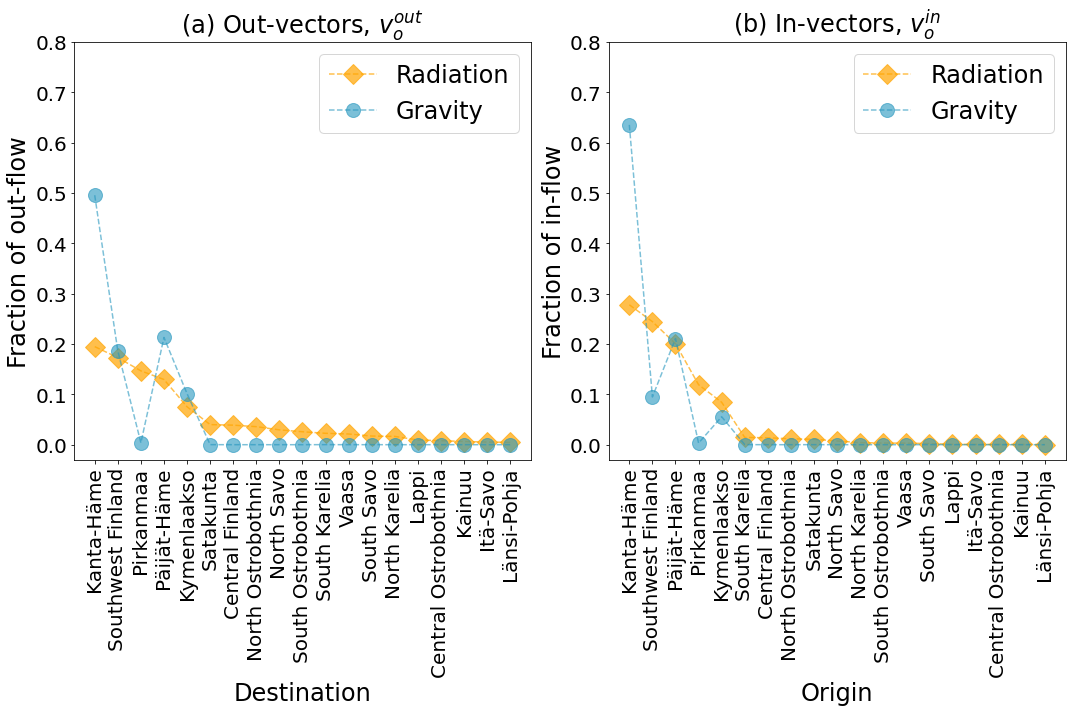

In [19]:
label_list, radiation_fraction_list = map(list, zip(*out_sig_radiation_list))
label_list_shortened = [short_labels_map[label] for label in label_list]
gravity_fraction_list = [out_sig_gravity[region] for region in label_list]
#plt.plot(label_list_shortened, fraction_list, ls = "--", marker = "o")
f = plt.figure(figsize = (15,10))
ax = f.add_subplot(1,2,1)
ax.plot(label_list_shortened, radiation_fraction_list, ls = "--", marker = "D", color = "orange", alpha = 0.7, label = "Radiation", markersize = 14)
ax.plot(label_list_shortened, gravity_fraction_list, ls = "--", marker = "o", color = "#2596be", alpha = 0.6, label = "Gravity", markersize = 14)
ax.set_ylabel("Fraction of out-flow", fontsize = 24)
ax.set_xlabel("Destination", fontsize = 24)
ax.set_ylim(-0.03, 0.8)
ax.tick_params(axis="y", labelsize=20)
ax.set_xticklabels(label_list_shortened, rotation = 90, fontsize = 20) 
#plt.xticks()
ax.set_title("(a) Out-vectors, "+"$v_{o}^{out}$", fontsize = 24)
ax.legend(fontsize = 24)

label_list, radiation_fraction_list = map(list, zip(*in_sig_radiation_list))
label_list_shortened = [short_labels_map[label] for label in label_list]
gravity_fraction_list = [in_sig_gravity[region] for region in label_list]
#plt.plot(label_list_shortened, fraction_list, ls = "--", marker = "o")
ax1 = f.add_subplot(1,2,2)
ax1.plot(label_list_shortened, radiation_fraction_list, ls = "--", marker = "D", color = "orange", alpha = 0.7, label = "Radiation", markersize = 14)
ax1.plot(label_list_shortened, gravity_fraction_list, ls = "--", marker = "o", color = "#2596be", alpha = 0.6, label = "Gravity", markersize = 14)
ax1.set_ylabel("Fraction of in-flow", fontsize = 24)
ax1.set_xlabel("Origin", fontsize = 24)
ax1.tick_params(axis="y", labelsize=20)
ax1.set_xticklabels(label_list_shortened, rotation = 90, fontsize = 20)
ax1.set_ylim(-0.03, 0.8)
#plt.xticks()
ax1.legend(fontsize = 24)
ax1.set_title("(b) In-vectors, "+"$v_{o}^{in}$", fontsize = 24)

plt.tight_layout()
plt.savefig('./results/plots/static_signatures.pdf')
plt.savefig('./results/plots/static_signatures.png', dpi=300)